In [0]:
import librosa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import pathlib
import csv

import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [0]:
!wget  http://opihi.cs.uvic.ca/sound/genres.tar.gz

--2020-05-10 06:25:23--  http://opihi.cs.uvic.ca/sound/genres.tar.gz
Resolving opihi.cs.uvic.ca (opihi.cs.uvic.ca)... 142.104.68.135
Connecting to opihi.cs.uvic.ca (opihi.cs.uvic.ca)|142.104.68.135|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1225571541 (1.1G) [application/x-gzip]
Saving to: ‘genres.tar.gz’

genres.tar.gz       100%[===================>]   1.14G   958KB/s    in 21m 8s  

2020-05-10 06:46:32 (944 KB/s) - ‘genres.tar.gz’ saved [1225571541/1225571541]



In [0]:
!gunzip genres.tar.gz
!tar -xvf genres.tar

genres/
genres/bextract_single.mf
genres/bl.mf
genres/blues/
genres/cl.mf
genres/classical/
genres/co.mf
genres/country/
genres/di.mf
genres/disco/
genres/hi.mf
genres/hiphop/
genres/input.mf
genres/ja.mf
genres/jazz/
genres/me.mf
genres/metal/
genres/po.mf
genres/pop/
genres/re.mf
genres/reggae/
genres/ro.mf
genres/rock/
genres/rock/rock.00000.wav
genres/rock/rock.00001.wav
genres/rock/rock.00002.wav
genres/rock/rock.00003.wav
genres/rock/rock.00004.wav
genres/rock/rock.00005.wav
genres/rock/rock.00006.wav
genres/rock/rock.00007.wav
genres/rock/rock.00008.wav
genres/rock/rock.00009.wav
genres/rock/rock.00010.wav
genres/rock/rock.00011.wav
genres/rock/rock.00012.wav
genres/rock/rock.00013.wav
genres/rock/rock.00014.wav
genres/rock/rock.00015.wav
genres/rock/rock.00016.wav
genres/rock/rock.00017.wav
genres/rock/rock.00018.wav
genres/rock/rock.00019.wav
genres/rock/rock.00020.wav
genres/rock/rock.00021.wav
genres/rock/rock.00022.wav
genres/rock/rock.00023.wav
genres/rock/rock.00024.wav
g

In [0]:
def getGenres():
  return ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']

# Classification based on features from the songs

# Features extraction

---
*   Mel-frequency cepstral coefficients (MFCC)(20 in number)
*   Spectral Centroid
*   Zero Crossing Rate
*   Chroma Frequencies
*   Spectral Roll-off







In [0]:

header = 'filename chroma_stft rmse spectral_centroid spectral_bandwidth rolloff zero_crossing_rate'
for i in range(1, 21):
    header += f' mfcc{i}'
header += ' label'
header = header.split()

file = open('data.csv', 'w', newline='')
with file:
    writer = csv.writer(file)
    writer.writerow(header)

genres = getGenres()
for g in genres:
    for filename in os.listdir(f'genres/{g}'):
        songname = f'genres/{g}/{filename}'
        y, sr = librosa.load(songname, mono=True, duration=30)
        chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
        rmse = librosa.feature.rmse(y=y)
        spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
        spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
        rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
        zcr = librosa.feature.zero_crossing_rate(y)
        mfcc = librosa.feature.mfcc(y=y, sr=sr)
        to_append = f'{filename} {np.mean(chroma_stft)} {np.mean(rmse)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)}'    
        for e in mfcc:
            to_append += f' {np.mean(e)}'
        to_append += f' {g}'
        file = open('data.csv', 'a', newline='')
        with file:
            writer = csv.writer(file)
            writer.writerow(to_append.split())

In [0]:
data = pd.read_csv('data.csv')
data = data.drop(['filename'],axis=1)
data.head()

,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,mfcc10,mfcc11,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
0,0.311780,0.106240,2279.895453,2119.726057,4732.338051,0.117149,-144.967922,95.726477,-21.598648,49.625746,-29.884746,29.353170,-18.844488,17.877581,-9.666900,5.505879,-9.546327,6.365179,-21.083879,2.452764,-9.533539,-1.422650,-9.327806,5.136750,-8.103219,-2.445027,blues
1,0.430894,0.196222,1946.565652,1979.909934,3955.867746,0.097454,-67.770980,111.704184,-34.646105,61.334896,0.050252,30.560614,-12.701725,21.159567,-13.131145,16.282294,-6.335245,12.295832,-12.477988,1.681278,-5.142068,4.644002,-6.919217,1.040718,-4.736871,-0.660037,blues
2,0.379428,0.123986,2148.786199,2204.574064,4673.663406,0.098812,-106.311032,102.630953,-20.155125,59.360374,-9.954544,33.689183,-14.170400,23.510001,-13.314068,16.014285,-18.916981,7.821363,-7.788122,4.047836,-11.340939,2.060218,-5.739426,0.464257,-1.909089,-3.128308,blues
3,0.255321,0.085868,1151.340441,1709.193938,2312.577683,0.035339,-301.686274,111.539209,21.895657,16.145590,8.191590,22.085966,-8.613639,1.491924,-17.074520,-8.337533,-17.011287,-10.572882,-15.687018,-12.598773,-12.245661,-14.543065,-10.092300,-5.780286,-7.776049,-7.186643,blues
4,0.248627,0.069145,1188.168337,1682.860150,2339.635853,0.048160,-328.673793,102.696873,19.876064,26.731257,7.158258,22.716643,-6.956797,12.804352,-10.708748,-0.419349,-12.363976,-8.897177,-9.238519,-9.109326,-9.003836,-7.640767,-7.190916,-9.368477,-4.470060,-3.688800,blues


In [0]:
data.shape

(1000, 27)

In [0]:
genre_list = data.iloc[:, -1]
# Extracting labels
encoder = LabelEncoder()
y = encoder.fit_transform(genre_list)

In [0]:
scaler = StandardScaler()
X = scaler.fit_transform(np.array(data.iloc[:, :-1], dtype = float))

In [0]:
from keras import models
from keras import layers

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

model = models.Sequential()

model.add(layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

In [0]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=20, validation_split=0.25, batch_size=128)

Train on 600 samples, validate on 200 samples
Epoch 1/20
600/600 [==============================] - 0s 499us/step - loss: 2.2331 - accuracy: 0.2383 - val_loss: 2.1231 - val_accuracy: 0.2850
Epoch 2/20
600/600 [==============================] - 0s 33us/step - loss: 1.9359 - accuracy: 0.3750 - val_loss: 1.9636 - val_accuracy: 0.3150
Epoch 3/20
600/600 [==============================] - 0s 34us/step - loss: 1.7365 - accuracy: 0.3850 - val_loss: 1.8175 - val_accuracy: 0.3400
Epoch 4/20
600/600 [==============================] - 0s 31us/step - loss: 1.5652 - accuracy: 0.4400 - val_loss: 1.6796 - val_accuracy: 0.3950
Epoch 5/20
600/600 [==============================] - 0s 33us/step - loss: 1.4244 - accuracy: 0.5183 - val_loss: 1.5918 - val_accuracy: 0.4200
Epoch 6/20
600/600 [==============================] - 0s 33us/step - loss: 1.3009 - accuracy: 0.5383 - val_loss: 1.5107 - val_accuracy: 0.4650
Epoch 7/20
600/600 [==============================] - 0s 32us/step - loss: 1.1895 - accuracy: 0

In [0]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.0571581363677978
Test accuracy: 0.6299999952316284


In [0]:
predictions = model.predict(X_test)
print('First prediction:', max(predictions[0]))

First prediction: 0.55172074


# Classification using MelSpectogram and CNN

In [0]:
import matplotlib.pyplot as plt
import librosa.display

sr = 22050

fmax = 10000 # Maximum frequency considered
fft_window_points = 512
fft_window_dur = fft_window_points * 1.0 / sr # 23ms windows
hop_size = int(fft_window_points/ 2) # 50% Overlap between consecutive frames
n_mels = 64

# Segment duration
num_fft_windows = 256 # Number of fft windows per music segment
segment_in_points = num_fft_windows * 255 # Number of data points that insure the spectrogram has size: 64 * 256
segment_dur = segment_in_points * 1.0 / sr

cmap = plt.get_cmap('inferno')
plt.figure(figsize=(10,10))

genres = getGenres()
for g in genres:
    pathlib.Path(f'mel_spectogram/{g}').mkdir(parents=True, exist_ok=True)     
    for filename in os.listdir(f'genres/{g}'):
        songname = f'genres/{g}/{filename}'
        y, sr = librosa.load(songname)
        S = librosa.feature.melspectrogram(y, sr=sr, n_fft=fft_window_points, 
                                   hop_length=hop_size, 
                                   n_mels=n_mels, fmax=fmax)
        S_DB = librosa.power_to_db(S, ref=np.max)
        librosa.display.specshow(S_DB, sr=sr, hop_length=hop_size, 
                         x_axis='time', y_axis='mel',fmax=fmax);
        plt.colorbar(format='%+2.0f dB');
        plt.savefig(f'mel_spectogram/{g}/{filename[:-3].replace(".", "")}.jpg')
        plt.clf()

<Figure size 720x720 with 0 Axes>

In [0]:
# cp -r mel_spectogram/ mel_spectogram_copy/

# Expected folder structure

*   modeldata
  *  train
     *  blues  
     *  classical  
     *  ....  
  *  test
     *  blues  
     *  classical  
     *  ....  
  *  validation
     *  blues  
     *  classical  
     *  ....  











In [0]:
import numpy as np
import os, shutil
import errno

original_dataset_dir = 'mel_spectogram'

base_dir = 'modeldata'
try:
  os.mkdir(base_dir)
except:
  pass

folders = [
  {'name': 'train', 'size': 80},
  {'name': 'test', 'size': 10},
  {'name': 'validation', 'size': 10}
]
for f in folders:
  directory = os.path.join(base_dir, f["name"])
  try:
    os.mkdir(directory)
  except OSError as exc:
    if exc.errno != errno.EEXIST:
      raise
    pass
  genres = getGenres()
  for g in genres:
    genre_directory = os.path.join(directory, g)
    try:
      os.mkdir(genre_directory)
    except:
      pass
    fnames = [f'{g}00{str(s).zfill(3)}.jpg' for s in range(f["size"])]
    for fname in fnames:
      src = os.path.join(original_dataset_dir+f'/{g}', fname)
      dst = os.path.join(genre_directory, fname)
      print(src)
      print(dst)
      shutil.copyfile(src, dst)

mel_spectogram/blues/blues00000.jpg
modeldata/train/blues/blues00000.jpg
mel_spectogram/blues/blues00001.jpg
modeldata/train/blues/blues00001.jpg
mel_spectogram/blues/blues00002.jpg
modeldata/train/blues/blues00002.jpg
mel_spectogram/blues/blues00003.jpg
modeldata/train/blues/blues00003.jpg
mel_spectogram/blues/blues00004.jpg
modeldata/train/blues/blues00004.jpg
mel_spectogram/blues/blues00005.jpg
modeldata/train/blues/blues00005.jpg
mel_spectogram/blues/blues00006.jpg
modeldata/train/blues/blues00006.jpg
mel_spectogram/blues/blues00007.jpg
modeldata/train/blues/blues00007.jpg
mel_spectogram/blues/blues00008.jpg
modeldata/train/blues/blues00008.jpg
mel_spectogram/blues/blues00009.jpg
modeldata/train/blues/blues00009.jpg
mel_spectogram/blues/blues00010.jpg
modeldata/train/blues/blues00010.jpg
mel_spectogram/blues/blues00011.jpg
modeldata/train/blues/blues00011.jpg
mel_spectogram/blues/blues00012.jpg
modeldata/train/blues/blues00012.jpg
mel_spectogram/blues/blues00013.jpg
modeldata/train

In [0]:
# rm -rf modeldata

In [0]:
from keras.preprocessing.image import ImageDataGenerator

batch_size = 150
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        directory='modeldata/train',  # this is the target directory
        target_size=(64, 256),  
        color_mode="rgb",
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(
        directory='modeldata/validation',  # this is the target directory
        target_size=(64, 256),  
        color_mode="rgb",
        batch_size=batch_size,
        class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
        directory='modeldata/test',  # this is the target directory
        target_size=(64, 256),  
        color_mode="rgb",
        batch_size=batch_size,
        class_mode='categorical')

Found 800 images belonging to 10 classes.
Found 100 images belonging to 10 classes.
Found 100 images belonging to 10 classes.


**CNN Classification**

In [0]:
import numpy as np
import tensorflow as tf 
from tensorflow import keras
from keras import models
from keras import layers
from keras import regularizers

model = models.Sequential()

model.add(layers.Conv2D(96, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01), input_shape=(64, 256, 3)))
model.add(layers.MaxPooling2D(pool_size=(2, 4)))
model.add(layers.Conv2D(64, (3, 5), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(layers.MaxPooling2D(pool_size=(2, 4)))
model.add(layers.Dropout(0.2))
model.add(layers.Flatten())
model.add(layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.02)))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(10, activation='softmax'))

In [0]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 62, 254, 96)       2688      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 63, 96)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 29, 59, 64)        92224     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 12544)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 32)               

In [0]:
opt = keras.optimizers.Adam(0.001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['acc'])

In [0]:
history = model.fit_generator(
                train_generator,
                steps_per_epoch= train_generator.labels.size//batch_size,
                epochs=60,
                validation_data=validation_generator,
                validation_steps= validation_generator.labels.size//batch_size,
                use_multiprocessing=True,
                workers=10)

model.predict_generator(test_generator, steps=None, callbacks=None, max_queue_size=10, workers=1, use_multiprocessing=False, verbose=0)

Epoch 1/60
5/5 [==============================] - 34s 7s/step - loss: 4.1843 - acc: 0.0969 - val_loss: 3.7124 - val_acc: 0.1000
Epoch 2/60

5/5 [==============================] - 35s 7s/step - loss: 3.5131 - acc: 0.1031 - val_loss: 3.2413 - val_acc: 0.1800
Epoch 3/60
5/5 [==============================] - 40s 8s/step - loss: 3.1146 - acc: 0.1107 - val_loss: 2.9517 - val_acc: 0.1000
Epoch 4/60
5/5 [==============================] - 36s 7s/step - loss: 2.8735 - acc: 0.1015 - val_loss: 2.7804 - val_acc: 0.1100
Epoch 5/60
5/5 [==============================] - 33s 7s/step - loss: 2.7262 - acc: 0.1291 - val_loss: 2.6660 - val_acc: 0.1300
Epoch 6/60
5/5 [==============================] - 40s 8s/step - loss: 2.6345 - acc: 0.1480 - val_loss: 2.5806 - val_acc: 0.2100
Epoch 7/60
5/5 [==============================] - 28s 6s/step - loss: 2.5417 - acc: 0.1523 - val_loss: 2.5031 - val_acc: 0.1700
Epoch 8/60
5/5 [==============================] - 38s 8s/step - loss: 2.4830 - acc: 0.1827 - val_loss: 

array([[2.11128548e-01, 2.37409219e-01, 5.21269776e-02, 6.61360286e-03,
        2.53804959e-02, 3.86178672e-01, 3.54226748e-03, 4.46143234e-03,
        5.75234517e-02, 1.56353079e-02],
       [2.47139394e-01, 8.34672302e-02, 4.25714962e-02, 1.62963290e-02,
        1.02744564e-01, 1.89617828e-01, 3.92706366e-03, 1.43000809e-02,
        2.60435760e-01, 3.95002551e-02],
       [1.09927148e-01, 2.53193490e-02, 6.07650075e-03, 1.35838659e-02,
        2.77265161e-01, 5.25951385e-02, 1.18834432e-03, 2.26884801e-02,
        4.74451452e-01, 1.69046000e-02],
       [2.32699171e-01, 3.11250594e-02, 5.66518568e-02, 2.15518177e-02,
        1.63332000e-01, 1.43270195e-01, 1.81466863e-02, 3.17165963e-02,
        2.34182864e-01, 6.73237368e-02],
       [8.59102011e-02, 3.00834849e-02, 2.40852889e-02, 2.22734466e-01,
        1.17650285e-01, 1.19625041e-02, 3.25609632e-02, 2.79919833e-01,
        9.93512049e-02, 9.57417712e-02],
       [8.34861845e-02, 4.61948067e-01, 6.89318925e-02, 3.71922716e-03,
   

In [0]:
score = model.evaluate_generator(test_generator)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.5455995798110962
Test accuracy: 0.5899999737739563


In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

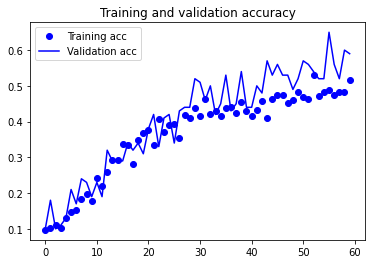

In [0]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.show()

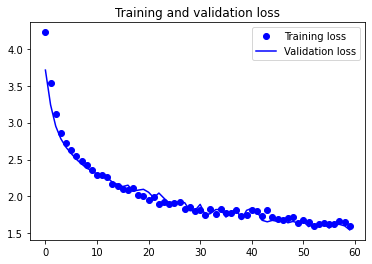

In [0]:
plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()